In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
print('Data shape',df.shape) #Printing dimensions of the data
df.head()

Data shape (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64
Fraud represents 0.173% of the dataset.


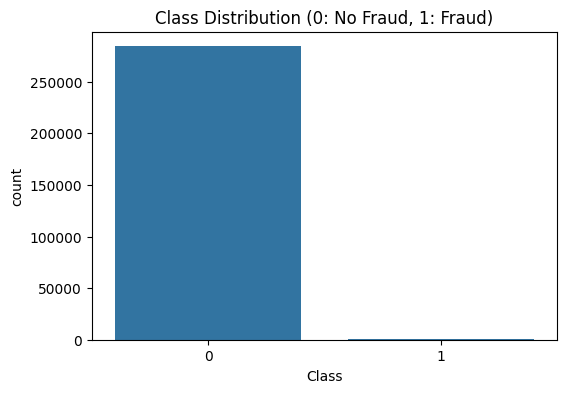

In [4]:
print(df['Class'].value_counts()) #counting number of zeros
fraud_share = df['Class'].value_counts()[1] / len(df)
print(f"Fraud represents {fraud_share*100:.3f}% of the dataset.")
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
plt.show()

In [5]:
from sklearn.preprocessing import RobustScaler

In [6]:
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df[['Time','Amount']].head()

,Time,Amount
0,-0.994983,1.783274
1,-0.994983,-0.269825
2,-0.994972,4.983721
3,-0.994972,1.418291
4,-0.994960,0.670579


In [7]:
from sklearn.model_selection import train_test_split

# X is the data (Features), y is the answer key (Target)
X = df.drop('Class', axis=1)
y = df['Class']

# Split: 80% for training, 20% for testing
# stratify=y ensures both sets have the same % of fraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

Training shape: (227845, 30)
Test shape: (56962, 30)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

y_pred = log_reg.predict(X_test)

print("---Baseline Model prediction--- ") #Evaluate how accurate the algorithm is currently
print(classification_report(y_test,y_pred))

---Baseline Model prediction--- 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [9]:
from imblearn.over_sampling import SMOTE 
'''SMOTE (Synthetic Minority Over-sampling Technique) creates new examples of fraud by drawing lines 
between existing fraud cases and creating a new point on that line. It's not copying; it's mathematically hallucinating plausible fraud.'''

print("Before smote: ",y_train.value_counts())
sm = SMOTE(random_state=83 ) #Because Barney always liked 83

X_train_res, y_train_res = sm.fit_resample(X_train,y_train)

print("After SMOTE",y_train_res.value_counts())

Before smote:  Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE Class
0    227451
1    227451
Name: count, dtype: int64


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state = 83)

# Train on the RESAMPLED data
rf_clf.fit(X_train_res, y_train_res)

# Predict on the ORIGINAL test set
y_pred_rf = rf_clf.predict(X_test)

--- Random Forest + SMOTE Results ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



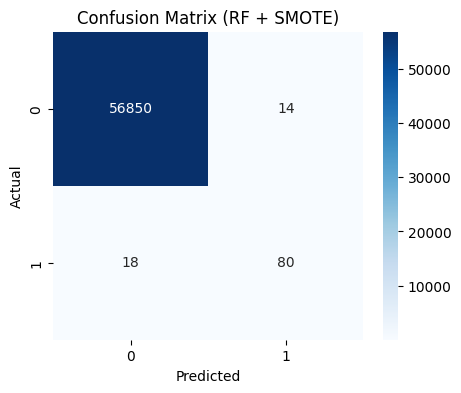

In [11]:
print("--- Random Forest + SMOTE Results ---")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix visualization
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (RF + SMOTE)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()